# Bayesian inference with pySam
pySam provides a simple implementation of Monte Carlo techniques such as importance sampling and sequential MC for static models.

The package contains a base class for Bayesian models `pysam.Model`

```python
class Model:
    
    def __init__(self): raise NotImplementedError
    def LogLikelihood(self,X): raise NotImplementedError
    def LogPrior(self,X): raise NotImplementedError
    def rPrior(self,X): raise NotImplementedError
    def Density(self,X): raise NotImplementedError
```
where `LogLikelihood`, `LogPrior` and `Density` are the data log likelihood, the log of the prior distribution of the model parameters, and `Density` is the probabilistic model. The user implementation of these functions must support vectorization, i.e. `X` can be a numpy array with set of parameters arranged by rows.

The main class implementing sampling methods is `pysam.Inference`. An instance of `pysam.Inference` is specified by a Model object

```python
def __init__(self,model):
        self.model = model
```

## Importance sampling 
Posterior averages can be obtained by using weighted samples obtained from an importance distribution used to approximate the posterior density. Importance weights are obtained as the ratio between the unnormalized posterior and the importance densities.
For simplicity, in pysam the importance distribution is identical to the prior. 

## Sequential Monte Carlo 
In pySam we implemented a tempered likelihood scheme to obtain a particle approximation of the posterior density. This corresponds to draw sequentially from the distributions

$$ \pi_k = \frac{1}{Z_k}P(data|\theta)^{h_k}\cdot P(\theta),\quad k=1,\cdots,q$$

where $h_0=0$ corresponds to the prior distribution and $h_q=1$ is the posterior distribution. Here $Z_k$ are the normalization constants and $Z_q$ is the marginal likelihood of the model. 

The method `pysam.SMC` corresponds to the following algorithm[1]

1. Initialization 
     * set $n=0$ 
     * draw $N$ particles corresponding to independent model parameters $\theta_{1:N}$ according to their prior distributions
     * Set importance weights to $1/N$ for all particles
     * Define a tempered protocol $h=\lbrace h_0=0,h_1,\cdots,h_{P-1},h_P=1\rbrace$
     * Iterate steps 2, 3 and 4
2. Resampling
     * Calculate the effective sample size (ESS)
     $$ESS = \left(\sum_k (W^{(k)})^2\right)^{-1}$$
     * when $ESS<N/2$ resample all particles and set their weights to $1/N$
3. Reweighting 
     * Reweight all particles using an incremental log weight of 
      $\log\tilde w = (h_{n+1}-h_{n}) \log P(data|\theta)$
     * recalculate and normalize all weights 
4. Move particles according to a Metropolis-Hastings kernel. 

## Example - Power law class

To illustrate the use of the pysam library we implemented a class corresponding to a power law model

In [1]:
import pysam
import scipy.stats as stat

class powerlaw(pysam.Model):
    def __init__(self,a,b):
        self.a=a
        self.b=b
        #self.data=None

    def LoadData(self,X):
        self.data=X
        self.M=X.shape[0]

    def LogPrior(self,x):
        return(stat.norm.logpdf(x,1,2))

    def rPrior(self,n):
        return(np.random.normal(1,2,n))

    def LogLikelihood(self,lam):
        zetamat=np.power.outer(1.0/np.arange(self.a,self.b+1),lam)
        zeta=np.sum(zetamat,0)
        nprod=-lam*np.sum(np.log(self.data))
        norm=-self.M*np.log(zeta)
        loglik=nprod+norm
        return(loglik)

Let us first generate some test data using an exponent of 1.6 

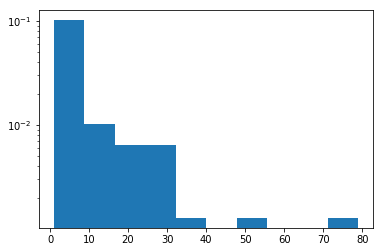

In [2]:
import numpy as np
import matplotlib.pyplot as plt
lam=1.6
density=1.0/np.arange(1,100)**lam
density=density/np.sum(density)
data=np.random.choice(np.arange(1,100),100,1,density)
fig, ax = plt.subplots()
ax.hist(data,density=1,log=True)
plt.show()

Now we can use these data to make inference on the exponent of the power law. First we define the model object (derived from the `pysam.Model` class) and load the data that we just generated

In [3]:
pl=powerlaw(min(data),max(data))
pl.LoadData(data)

then we introduce an instance of `pysam.Inference` initialized using `pl` and use the SMC method to generate posterior samples

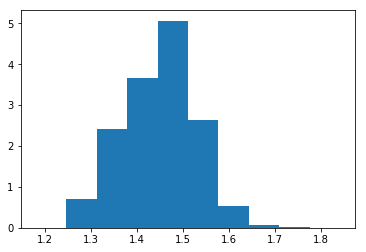

In [4]:
I = pysam.Inference(pl)
I.SMC(200,4)
I.plot_samples()

Analogously we can replace the code above to employ a simpler importance sampling method

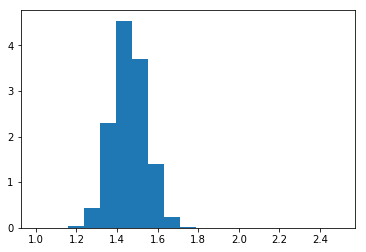

In [5]:
I_is = pysam.Inference(pl)
I_is.IS(20000)
I_is.plot_samples([1,2.5])

We can now compare the (log) marginal likelihood obtained with the two methods. We have

In [8]:
print("Log Marginal Likelihood from SMC = ", I.LML)
print("Log Marginal Likelihood from IS = ", I_is.LML,"\n")

Log Marginal Likelihood from SMC =  -256.140996973
Log Marginal Likelihood from IS =  -256.642476954 



## References
[1] Del Moral, Pierre, Arnaud Doucet, and Ajay Jasra. "Sequential monte carlo samplers." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 68.3 (2006): 411-436.